# PSO Parameter Sensitivity on Knapsack (Discrete)

**Parameter sensitivity analysis** for a Particle Swarm Optimizer (PSO) on a **0–1 Knapsack** benchmark.

**What this notebook does:**
- Runs PSO on a binary Knapsack instance (items, weights, capacity given in text files).
- Uses a *continuous* PSO on [0, 1]^d and decodes particles to 0/1 item choices.
- Performs **1D sweeps** (e.g., population size, inertia weight) → line plots (mean ± std).
- Performs **2D sweeps** over `(phi1, phi2)` for constriction PSO → heatmaps.
- Tracks metrics: best (minimized) objective, best **profit**, relative-to-optimal, hit-rate@ε, iterations-to-ε, and AUC of the convergence curve.


In [8]:
import time
from typing import List, Tuple, Optional, Dict
import numpy as np
import matplotlib.pyplot as plt

# Project modules
from problem.knapsack import Knapsack
from swarm_algo.pso import ParticleSwarmOptimizer

# Folder to save figures 
import os

OUT_PATH = "../imgs/pso_knapsack/"  

if not os.path.exists(OUT_PATH):
    os.makedirs(OUT_PATH, exist_ok=True)

In [9]:
# ---- Knapsack from project module ----
KNAPSACK_DATA_FOLDER = "../data/knapsack/"  # adjust if your data is elsewhere

def get_knapsack_problem(problem_number: int) -> Tuple[int, Knapsack, int]:
    """
    Load a knapsack problem instance.

    Returns
    -------
    n_items : int
        Number of decision variables (items).
    prob : Knapsack
        Problem object with capacity, items (profits), weights, and known solution.
    opt_profit : int
        Profit of the known optimal solution (from .solution file).
    """
    prob = Knapsack(PROBLEM_FOLDER=KNAPSACK_DATA_FOLDER, PROBLEM=problem_number)
    n_items = len(prob.items)
    opt_profit = int(prob.calculate_fitness(prob.solution))
    return n_items, prob, opt_profit


def decode_position_to_solution(x: np.ndarray, prob: Knapsack) -> np.ndarray:
    """
    Map a continuous position vector x \in [0, 1]^d to a 0/1 selection vector.

    Simple rule: item i is taken iff x[i] > 0.5.
    The knapsack capacity constraint is handled *inside* `calculate_fitness`:
    overweight solutions simply get fitness 0.
    """
    x = np.asarray(x, dtype=float)
    if x.ndim != 1:
        raise ValueError(f"Expected 1D position vector, got shape {x.shape}")
    if x.size != len(prob.items):
        raise ValueError(f"Position length {x.size} != number of items {len(prob.items)}")
    return (x > 0.5).astype(int)


def knapsack_objective(x: np.ndarray, problem: Knapsack) -> float:
    """
    Objective passed to PSO.

    PSO in this project is implemented for **minimization**, so we minimize
    the *negative* profit:  f(x) = -profit(selection(x)).
    """
    sol = decode_position_to_solution(x, problem)
    profit = problem.calculate_fitness(sol)
    return -float(profit)


<>:24: SyntaxWarning: invalid escape sequence '\i'
<>:24: SyntaxWarning: invalid escape sequence '\i'
C:\Users\admin\AppData\Local\Temp\ipykernel_20712\1393275230.py:24: SyntaxWarning: invalid escape sequence '\i'
  """


In [10]:
# ---- Metrics ----
def convergence_auc(history: List[float]) -> float:
    """AUC of best-so-far curve (lower is better, since we minimize)."""
    y = np.asarray(history, dtype=float)
    x = np.arange(len(y))
    return float(np.trapezoid(y, x))


def iters_to_epsilon(history: List[float], eps: float) -> Optional[int]:
    """
    First iteration index where best-so-far <= eps.

    For knapsack we work with f(x) = -profit(x), so a smaller value means
    *higher* profit. `eps` is defined in terms of this minimized objective.
    """
    y = np.asarray(history, dtype=float)
    idx = np.where(y <= eps)[0]
    return int(idx[0]) if idx.size > 0 else None


def summarize(values: List[float]) -> Tuple[float, float]:
    a = np.asarray(values, dtype=float)
    return float(a.mean()), float(a.std())


In [11]:
# ---- Single PSO run on Knapsack ----
def run_single_pso_knapsack(
    problem_number: int,
    max_iters: int,
    n_particles: int,
    seed: int,
    # PSO mode & parameters
    mode: str = "constriction",                # "constriction" | "inertia" | others supported by your PSO
    phi1: float = 2.05, phi2: float = 2.05,    # cognitive / social coeffs for constriction-style PSO
    chi: Optional[float] = 0.729,              # constriction factor
    w: Tuple[float, float] = (0.9, 0.4),       # (w_start, w_end) for inertia PSO
    c1: float = 2.0, c2: float = 2.0,          # acceleration coefficients for inertia PSO
    topology: str = "ring", ring_neighbors: int = 2,
    velocity_clamp: float = 0.5,               # clamp velocity in [-vmax, vmax] where vmax = velocity_clamp * span
    boundary_mode: str = "clip",               # how to handle positions out of [0, 1]
    # Stopping / evaluation
    eps_ratio: float = 0.99,                   # hit if profit >= eps_ratio * optimal_profit
    early_stopping_rounds: Optional[int] = None,
    tol: float = 1e-6,
) -> Dict[str, float]:
    """
    Run a single PSO on a Knapsack instance and return metrics.

    Notes
    -----
    - We treat the search space as [0, 1]^d and decode to 0/1 using a threshold.
    - Objective is f(x) = -profit, so *smaller* is better.
    - `eps_ratio` is defined relative to the known optimal profit from the data file.
    """
    d, prob, opt_profit = get_knapsack_problem(problem_number)
    bounds = [(0.0, 1.0)] * d

    # Target in terms of minimized objective: f(x) = -profit(x)
    # We hit when best_f <= -eps_ratio * opt_profit.
    eps_target = -float(opt_profit) * float(eps_ratio)

    t0 = time.perf_counter()
    pso = ParticleSwarmOptimizer(
        objective=lambda x: knapsack_objective(x, prob),
        bounds=bounds,
        n_particles=n_particles,
        max_iters=max_iters,
        mode=mode,
        phi1=phi1, phi2=phi2, chi=chi,
        w=w, c1=c1, c2=c2,
        topology=topology, ring_neighbors=ring_neighbors,
        velocity_clamp=velocity_clamp,
        boundary_mode=boundary_mode,
        seed=seed,
        enable_position_history=False,
        track_positions=False,
        early_stopping_rounds=early_stopping_rounds,
        tol=tol,
        # We still use "continuous" here because the PSO moves in a continuous space,
        # and we handle the discrete decoding inside the objective.
        problem_type="continuous",
    )
    best_x, best_f, info = pso.optimize()
    dt = time.perf_counter() - t0

    # Decode best solution to get actual profit & relative performance
    best_sol = decode_position_to_solution(best_x, prob)
    best_profit = float(prob.calculate_fitness(best_sol))
    rel_to_opt = float(best_profit / opt_profit) if opt_profit > 0 else np.nan

    auc = convergence_auc(info.history_best_f)
    iters_eps = iters_to_epsilon(info.history_best_f, eps_target)
    hit = 1.0 if (iters_eps is not None) else 0.0

    return dict(
        best_f=best_f,                     # minimized objective = -best_profit
        best_profit=best_profit,           # actual profit of decoded best solution
        rel_to_opt=rel_to_opt,             # best_profit / optimal_profit
        auc=auc,
        iters_to_eps=(iters_eps if iters_eps is not None else np.nan),
        hit=hit,
        time=dt,
        n_iter=info.n_iter,
    )

In [12]:
# ---- 1D sweep ----
def sweep_1d(
    problem_number: int,
    param_name: str,
    values: List,
    seeds: List[int],
    budget: Dict[str, int],
    mode_cfg: Dict = None,
) -> Dict:
    if mode_cfg is None:
        mode_cfg = {}

    res = {
        "param": [],
        "best_f_mean": [], "best_f_std": [],
        "best_profit_mean": [], "best_profit_std": [],
        "rel_mean": [], "rel_std": [],
        "hit_rate": [],
        "iters_mean": [], "iters_std": [],
        "auc_mean": [], "auc_std": [],
    }

    for v in values:
        metrics = []
        for s in seeds:
            cfg = dict(
                problem_number=problem_number,
                seed=s,
                max_iters=budget["max_iters"],
                n_particles=budget["n_particles"],
                **mode_cfg,
            )
            cfg[param_name] = v
            m = run_single_pso_knapsack(**cfg)
            metrics.append(m)

        best_f = [m["best_f"] for m in metrics]
        best_profit = [m["best_profit"] for m in metrics]
        rel = [m["rel_to_opt"] for m in metrics]
        aucs = [m["auc"] for m in metrics]
        iters = [m["iters_to_eps"] for m in metrics if not np.isnan(m["iters_to_eps"])]
        hits = [m["hit"] for m in metrics]

        bf_mean, bf_std = summarize(best_f)
        bp_mean, bp_std = summarize(best_profit)
        rel_mean, rel_std = summarize(rel)
        auc_mean, auc_std = summarize(aucs)
        it_mean = float(np.mean(iters)) if len(iters) > 0 else np.nan
        it_std = float(np.std(iters)) if len(iters) > 0 else np.nan
        hit_rate = float(np.mean(hits))

        res["param"].append(v)
        res["best_f_mean"].append(bf_mean);         res["best_f_std"].append(bf_std)
        res["best_profit_mean"].append(bp_mean);    res["best_profit_std"].append(bp_std)
        res["rel_mean"].append(rel_mean);           res["rel_std"].append(rel_std)
        res["auc_mean"].append(auc_mean);           res["auc_std"].append(auc_std)
        res["iters_mean"].append(it_mean);          res["iters_std"].append(it_std)
        res["hit_rate"].append(hit_rate)

    return res


# ---- 2D sweep ----
def sweep_2d(
    problem_number: int,
    x_name: str, x_vals: List,
    y_name: str, y_vals: List,
    seeds: List[int],
    budget: Dict[str, int],
    mode_cfg: Dict = None,
    metric: str = "best_f",  # 'best_f' | 'best_profit' | 'auc' | 'hit' | 'iters' | 'rel'
) -> Dict:
    if mode_cfg is None:
        mode_cfg = {}

    H = np.zeros((len(y_vals), len(x_vals)), dtype=float)

    for iy, yv in enumerate(y_vals):
        for ix, xv in enumerate(x_vals):
            metrics = []
            for s in seeds:
                cfg = dict(
                    problem_number=problem_number,
                    seed=s,
                    max_iters=budget["max_iters"],
                    n_particles=budget["n_particles"],
                    **mode_cfg,
                )
                cfg[x_name] = xv
                cfg[y_name] = yv
                m = run_single_pso_knapsack(**cfg)
                metrics.append(m)

            if metric == "best_f":
                vals = [m["best_f"] for m in metrics]
            elif metric == "best_profit":
                vals = [m["best_profit"] for m in metrics]
            elif metric == "rel":
                vals = [m["rel_to_opt"] for m in metrics]
            elif metric == "auc":
                vals = [m["auc"] for m in metrics]
            elif metric == "hit":
                vals = [m["hit"] for m in metrics]
            elif metric == "iters":
                vals = [m["iters_to_eps"] for m in metrics if not np.isnan(m["iters_to_eps"])]
            else:
                raise ValueError("Unknown metric")

            H[iy, ix] = np.mean(vals) if len(vals) > 0 else np.nan

    return {
        "X": x_vals,
        "Y": y_vals,
        "H": H,
        "metric": metric,
        "x_name": x_name,
        "y_name": y_name,
    }

In [13]:
# ---- Plotting ----
def plot_line_with_error(x, y, yerr, title, xlabel, ylabel, out_path=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    x_arr = np.asarray(x, dtype=float)
    y_arr = np.asarray(y, dtype=float)
    e_arr = np.asarray(yerr, dtype=float)
    ax.plot(x_arr, y_arr, marker="o")
    ax.errorbar(x_arr, y_arr, yerr=e_arr, fmt="none", alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    if out_path:
        plt.savefig(out_path)
    plt.show()


def plot_heatmap(res2d: Dict, title: str, out_path=None):
    X = res2d["X"]; Y = res2d["Y"]; H = res2d["H"]
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(H, cmap="viridis", origin="upper", aspect="auto")
    fig.colorbar(im, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(res2d["x_name"])
    ax.set_ylabel(res2d["y_name"])
    ax.set_xticks(range(len(X)))
    ax.set_xticklabels([str(v) for v in X], rotation=0)
    ax.set_yticks(range(len(Y)))
    ax.set_yticklabels([str(v) for v in Y])
    if out_path:
        plt.savefig(out_path)
    plt.show()

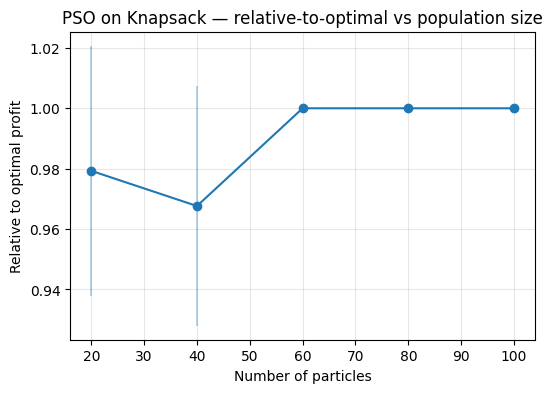

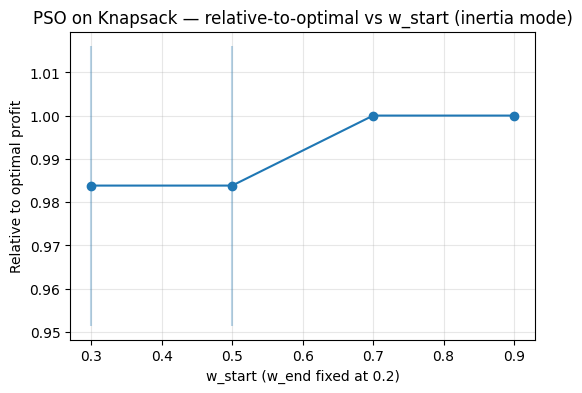

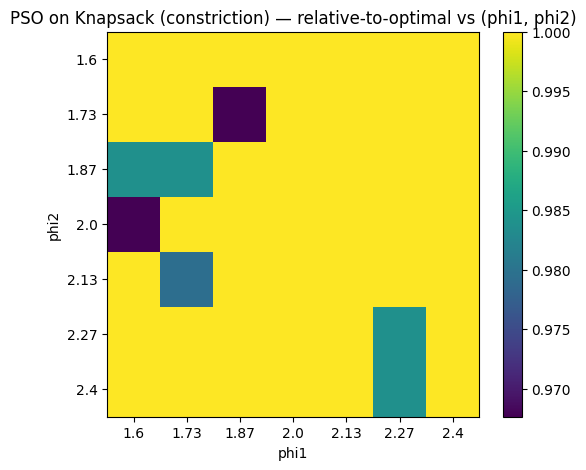

In [ ]:
# ---- Experiment Config ----
PROBLEM_NUMBER = 1          # choose a knapsack instance: p01, p02, ...
SEEDS = list(range(5))      # increase to 10/20 in real experiments
BUDGET = {"max_iters": 400, "n_particles": 50}

# ---- 1D Sweep: population size ----
pop_values = [20, 40, 60, 80, 100]
res_pop = sweep_1d(
    problem_number=PROBLEM_NUMBER,
    param_name="n_particles",
    values=pop_values,
    seeds=SEEDS,
    budget=dict(max_iters=BUDGET["max_iters"], n_particles=BUDGET["n_particles"]),
    mode_cfg=dict(mode="constriction", phi1=2.05, phi2=2.05, chi=0.729),
)
plot_line_with_error(
    pop_values,
    res_pop["rel_mean"],
    res_pop["rel_std"],
    title="PSO on Knapsack — relative-to-optimal vs population size",
    xlabel="Number of particles",
    ylabel="Relative to optimal profit",
    out_path=OUT_PATH + "pso_knapsack_line_population_rel.png",
)


# ---- 1D Sweep: inertia weight (for inertia PSO) ----
w_start_values = [0.3, 0.5, 0.7, 0.9]
res_w = sweep_1d(
    problem_number=PROBLEM_NUMBER,
    param_name="w",
    values=[(w0, 0.2) for w0 in w_start_values],
    seeds=SEEDS,
    budget=BUDGET,
    mode_cfg=dict(mode="inertia", c1=1.7, c2=1.7),
)
plot_line_with_error(
    w_start_values,
    res_w["rel_mean"],
    res_w["rel_std"],
    title="PSO on Knapsack — relative-to-optimal vs w_start (inertia mode)",
    xlabel="w_start (w_end fixed at 0.2)",
    ylabel="Relative to optimal profit",
    out_path=OUT_PATH + "pso_knapsack_line_wstart_rel.png",
)


# ---- 2D Sweep: constriction phi1 × phi2 ----
phi_grid = np.round(np.linspace(1.6, 2.4, 7), 2).tolist()
res_phi = sweep_2d(
    problem_number=PROBLEM_NUMBER,
    x_name="phi1", x_vals=phi_grid,
    y_name="phi2", y_vals=phi_grid,
    seeds=SEEDS,
    budget=BUDGET,
    mode_cfg=dict(mode="constriction", chi=0.729),
    metric="rel",  # visualize relative-to-optimal
)
plot_heatmap(
    res_phi,
    title="PSO on Knapsack (constriction) — relative-to-optimal vs (phi1, phi2)",
    out_path=OUT_PATH + "pso_knapsack_heatmap_phi1_phi2_rel.png",
)
